# Base Sequence Content QC for NGS Data

This notebook demonstrates how to use the `base_content` function from the `polars_bio.qc` module to analyze the base sequence content of FASTQ files. This QC operation helps identify biases or issues in the sequencing process by showing the distribution of nucleotide bases (A, T, G, C, N) at each position in the reads.

In [1]:
import polars_bio as pb
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


# Set plotting style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

INFO:polars_bio:Creating BioSessionContext


## Loading FASTQ Data

First, let's load a FASTQ file using the `read_fastq` function from polars-bio. We'll use the example FASTQ file from the fastqc-rs project.

In [2]:
# Path to the example FASTQ file
fastq_file = "../tests/data/example_small.fastq"

# Read the FASTQ file
pb.read_fastq(fastq_file).collect()
df = pb.read_fastq(fastq_file).collect()


INFO:polars_bio:Table: example_small registered for path: ../tests/data/example_small.fastq


0rows [00:00, ?rows/s]

INFO:polars_bio:Table: example_small registered for path: ../tests/data/example_small.fastq


0rows [00:00, ?rows/s]

In [3]:
# Register the DataFrame as a table
pb.sql("show tables;").collect()


0rows [00:00, ?rows/s]

table_catalog,table_schema,table_name,table_type
str,str,str,str
"""datafusion""","""public""","""examples""","""BASE TABLE"""
"""datafusion""","""information_schema""","""tables""","""VIEW"""
"""datafusion""","""information_schema""","""views""","""VIEW"""
"""datafusion""","""information_schema""","""columns""","""VIEW"""
"""datafusion""","""information_schema""","""df_settings""","""VIEW"""
"""datafusion""","""information_schema""","""schemata""","""VIEW"""


In [6]:
pb.sql("select count(*) from example_small limit 10").collect()

0rows [00:00, ?rows/s]

count(*)
i64
200


In [18]:
pb.sql("describe example_small").collect()
pb.sql("select base_content(sequence) from example_small;").collect()


0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

base_content(example_small.sequence)
struct[6]
"{0,42.0,51.0,48.0,46.0,13.0}"
"{1,48.0,51.0,40.0,61.0,0.0}"
"{2,57.0,51.0,43.0,49.0,0.0}"
"{3,45.0,48.0,52.0,55.0,0.0}"
"{4,57.0,45.0,46.0,52.0,0.0}"
…
"{96,54.0,42.0,52.0,45.0,7.0}"
"{97,46.0,44.0,52.0,47.0,11.0}"
"{98,46.0,55.0,52.0,47.0,0.0}"


0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

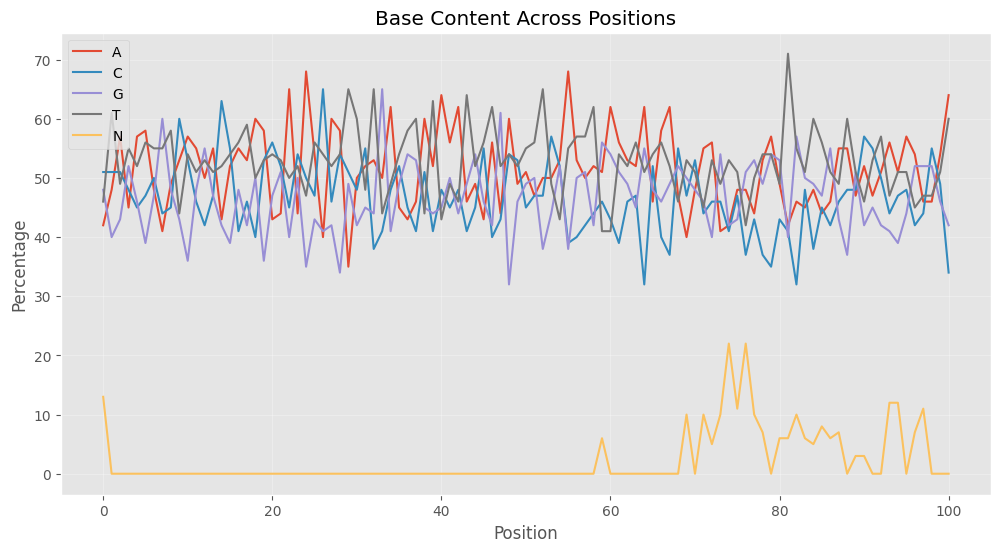

[{"position":0,"A":42.0,"C":51.0,"G":48.0,"T":46.0,"N":13.0},{"position":1,"A":48.0,"C":51.0,"G":40.0,"T":61.0,"N":0.0},{"position":2,"A":57.0,"C":51.0,"G":43.0,"T":49.0,"N":0.0},{"position":3,"A":45.0,"C":48.0,"G":52.0,"T":55.0,"N":0.0},{"position":4,"A":57.0,"C":45.0,"G":46.0,"T":52.0,"N":0.0},{"position":5,"A":58.0,"C":47.0,"G":39.0,"T":56.0,"N":0.0},{"position":6,"A":48.0,"C":50.0,"G":47.0,"T":55.0,"N":0.0},{"position":7,"A":41.0,"C":44.0,"G":60.0,"T":55.0,"N":0.0},{"position":8,"A":49.0,"C":45.0,"G":48.0,"T":58.0,"N":0.0},{"position":9,"A":53.0,"C":60.0,"G":43.0,"T":44.0,"N":0.0},{"position":10,"A":57.0,"C":53.0,"G":36.0,"T":54.0,"N":0.0},{"position":11,"A":55.0,"C":46.0,"G":48.0,"T":51.0,"N":0.0},{"position":12,"A":50.0,"C":42.0,"G":55.0,"T":53.0,"N":0.0},{"position":13,"A":55.0,"C":47.0,"G":47.0,"T":51.0,"N":0.0},{"position":14,"A":43.0,"C":63.0,"G":42.0,"T":52.0,"N":0.0},{"position":15,"A":52.0,"C":55.0,"G":39.0,"T":54.0,"N":0.0},{"position":16,"A":55.0,"C":41.0,"G":48.0,"T":56

position,A,C,G,T,N,GC_content
f64,f64,f64,f64,f64,f64,f64
50.0,51.475248,46.653465,46.732673,52.881188,2.257426,46.693069


In [62]:
pb.sql("select base_content(sequence) from example_small;").collect()
pb.ctx.set_option("datafusion.execution.target_partitions", str(2))
pb.sql("select base_content(sequence) from example_small;").collect()
df1 = pb.sql("SELECT base_content(sequence) as base FROM example_small").collect()
df1 = df1.unnest("base")
pb.qc.visualize_base_content(df1)
json_str = df1.write_json()
print(json_str)
gc_df = df1.with_columns(
        ((pl.col("G") + pl.col("C")) / (pl.col("A") + pl.col("C") + pl.col("G") + pl.col("T") + pl.col("N")) * 100).alias("GC_content")
    )
print(gc_df)
gc_df.mean()

## Analyzing Base Sequence Content

Now, let's analyze the base sequence content using the `base_content` function. This function calculates the percentage of each base (A, T, G, C, N) at each position in the reads.

In [17]:
# Calculate base content
base_content_df = pb.qc.base_content(df)

# Display the first few rows of the result
base_content_df.head()

Chunk size: 70400
Successfully calculated base content, column count: 101


position,A,C,G,T,N
i32,f64,f64,f64,f64,f64
0,21.0,25.5,24.0,23.0,6.5
1,24.0,25.5,20.0,30.5,0.0
2,28.5,25.5,21.5,24.5,0.0
3,22.5,24.0,26.0,27.5,0.0
4,28.5,22.5,23.0,26.0,0.0


In [18]:
base_content_df = base_content_df.with_columns(
    pl.sum_horizontal(['A', 'C', 'G', 'T', 'N']).alias('total')
)
print(base_content_df)

shape: (101, 7)
┌──────────┬──────┬──────┬──────┬──────┬─────┬───────┐
│ position ┆ A    ┆ C    ┆ G    ┆ T    ┆ N   ┆ total │
│ ---      ┆ ---  ┆ ---  ┆ ---  ┆ ---  ┆ --- ┆ ---   │
│ i32      ┆ f64  ┆ f64  ┆ f64  ┆ f64  ┆ f64 ┆ f64   │
╞══════════╪══════╪══════╪══════╪══════╪═════╪═══════╡
│ 0        ┆ 21.0 ┆ 25.5 ┆ 24.0 ┆ 23.0 ┆ 6.5 ┆ 100.0 │
│ 1        ┆ 24.0 ┆ 25.5 ┆ 20.0 ┆ 30.5 ┆ 0.0 ┆ 100.0 │
│ 2        ┆ 28.5 ┆ 25.5 ┆ 21.5 ┆ 24.5 ┆ 0.0 ┆ 100.0 │
│ 3        ┆ 22.5 ┆ 24.0 ┆ 26.0 ┆ 27.5 ┆ 0.0 ┆ 100.0 │
│ 4        ┆ 28.5 ┆ 22.5 ┆ 23.0 ┆ 26.0 ┆ 0.0 ┆ 100.0 │
│ …        ┆ …    ┆ …    ┆ …    ┆ …    ┆ …   ┆ …     │
│ 96       ┆ 27.0 ┆ 21.0 ┆ 26.0 ┆ 22.5 ┆ 3.5 ┆ 100.0 │
│ 97       ┆ 23.0 ┆ 22.0 ┆ 26.0 ┆ 23.5 ┆ 5.5 ┆ 100.0 │
│ 98       ┆ 23.0 ┆ 27.5 ┆ 26.0 ┆ 23.5 ┆ 0.0 ┆ 100.0 │
│ 99       ┆ 27.0 ┆ 24.5 ┆ 23.0 ┆ 25.5 ┆ 0.0 ┆ 100.0 │
│ 100      ┆ 32.0 ┆ 17.0 ┆ 21.0 ┆ 30.0 ┆ 0.0 ┆ 100.0 │
└──────────┴──────┴──────┴──────┴──────┴─────┴───────┘


## Visualizing Base Sequence Content

Let's visualize the base content distribution across positions using the `visualize_base_content` function.

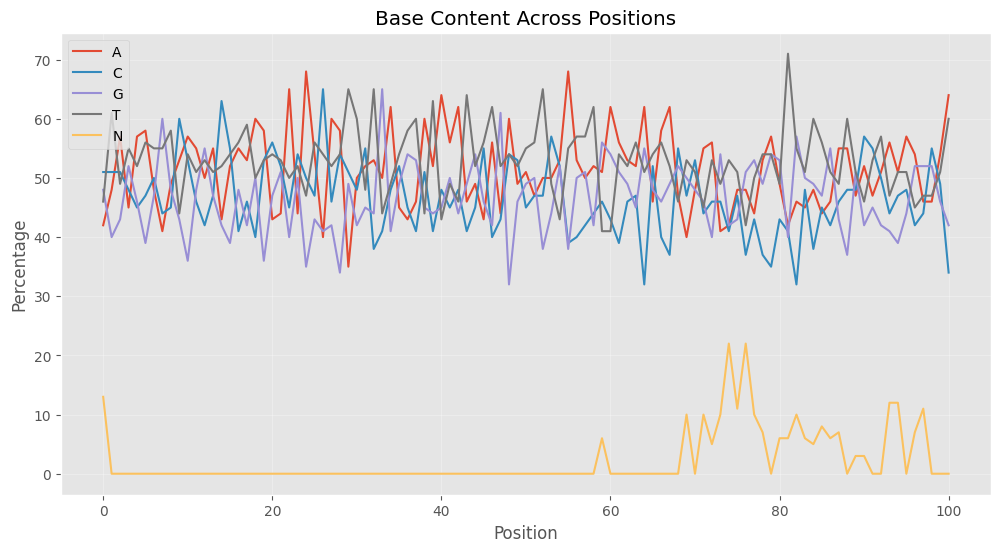

In [22]:
# Visualize base content
pb.qc.visualize_base_content(df1)

## Custom Visualization

We can also create a custom visualization of the base content data using matplotlib directly.

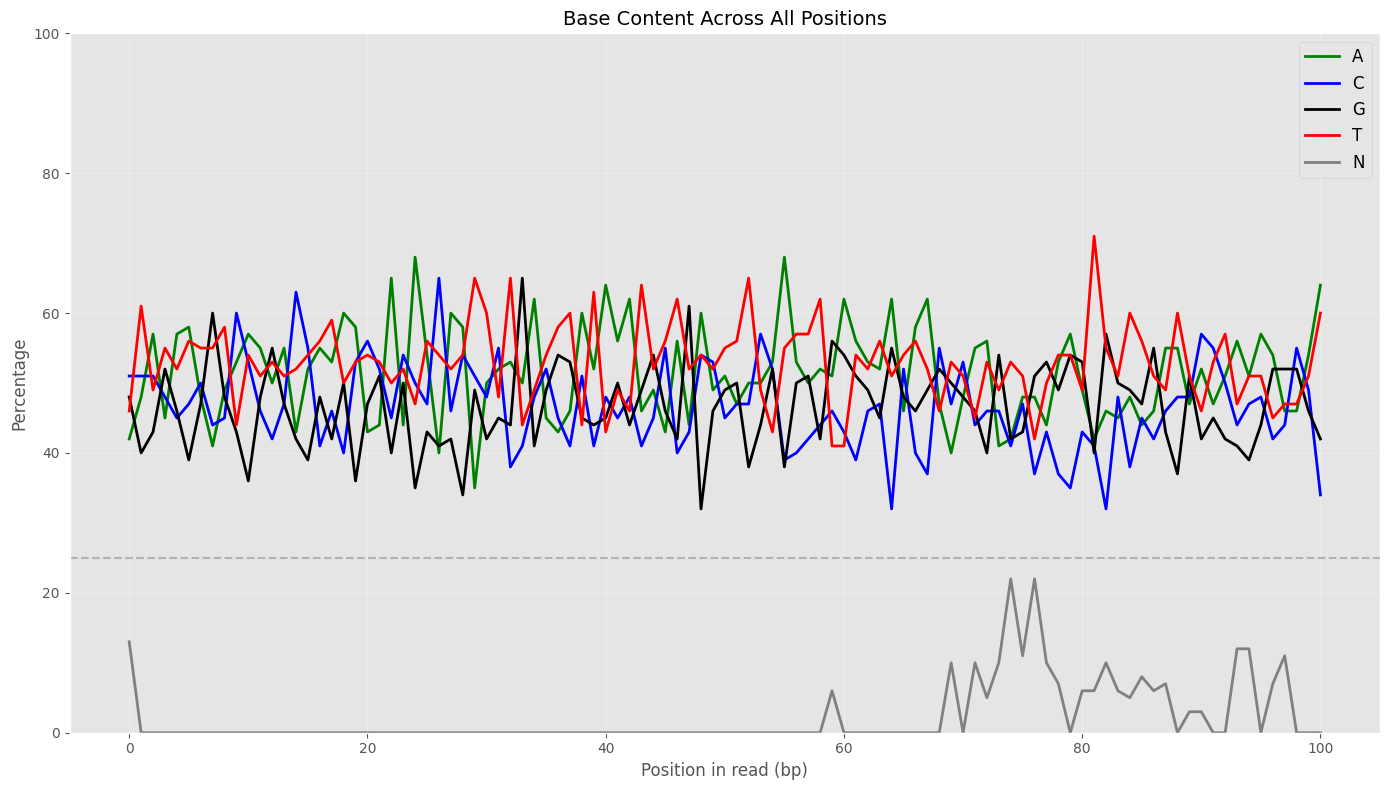

In [21]:
# Convert to pandas for easier plotting
pdf = df1.to_pandas()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each base
ax.plot(pdf['position'], pdf['A'], '-', label='A', color='green', linewidth=2)
ax.plot(pdf['position'], pdf['C'], '-', label='C', color='blue', linewidth=2)
ax.plot(pdf['position'], pdf['G'], '-', label='G', color='black', linewidth=2)
ax.plot(pdf['position'], pdf['T'], '-', label='T', color='red', linewidth=2)
ax.plot(pdf['position'], pdf['N'], '-', label='N', color='gray', linewidth=2)

# Add a horizontal line at 25% (expected for random distribution)
ax.axhline(y=25, color='gray', linestyle='--', alpha=0.5)

# Set labels and title
ax.set_xlabel('Position in read (bp)', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_title('Base Content Across All Positions', fontsize=14)

# Add legend
ax.legend(fontsize=12)

# Set y-axis limits
ax.set_ylim(0, 100)

# Add grid
ax.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

## Analyzing Base Content with Different Input Types

The `base_content` function supports different input types, including Polars DataFrame, Polars LazyFrame, and Pandas DataFrame. Let's demonstrate this flexibility.

In [17]:
# Using a Polars LazyFrame
lazy_df = df.lazy()
lazy_result = pb.qc.base_content(lazy_df)
print(f"Result type with LazyFrame input: {type(lazy_result)}")
lazy_result.head()

Successfully calculated base content, row count: 438
Result type with LazyFrame input: <class 'polars.dataframe.frame.DataFrame'>


position,A,C,G,T,N
i32,f64,f64,f64,f64,f64
0,2.253775,41.311697,46.743295,9.691233,0.0
1,27.65382,1.825558,34.550372,35.97025,0.0
2,15.663737,2.681992,25.467658,56.186613,0.0
3,13.657877,4.50755,35.406806,46.427767,0.0
4,17.421681,8.541808,31.778229,42.258283,0.0


In [18]:
# Using a Pandas DataFrame
pandas_df = df.to_pandas()
pandas_result = pb.qc.base_content(pandas_df, output_type="pandas.DataFrame")
print(f"Result type with Pandas DataFrame input: {type(pandas_result)}")
pandas_result.head()

Successfully calculated base content, row count: 438
Result type with Pandas DataFrame input: <class 'pandas.core.frame.DataFrame'>


,position,A,C,G,T,N
0,0,2.253775,41.311697,46.743295,9.691233,0.0
1,1,27.653820,1.825558,34.550372,35.970250,0.0
2,2,15.663737,2.681992,25.467658,56.186613,0.0
3,3,13.657877,4.507550,35.406806,46.427767,0.0
4,4,17.421681,8.541808,31.778229,42.258283,0.0


## Performance Comparison

Let's compare the performance of the base content calculation with different numbers of threads.

### Here is code with AVX-256 support

In [5]:
import time
import os
print(f"Number of CPU cores: {os.cpu_count()}")
# Define a function to measure execution time
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

# Test with different numbers of threads
thread_counts = [1, 2, 4, 8]
execution_times = []
execution_times_sql = []
for threads in thread_counts:
    # Set the number of threads
    pb.ctx.set_option("datafusion.execution.target_partitions", str(threads))

    start_time = time.time()
    pb.sql("select base_content(sequence) from example").collect()
    end_time = time.time()
    execution_time_sql = end_time - start_time
    execution_times_sql.append(execution_time_sql)
    # Measure execution time
    _, execution_time = measure_time(pb.qc.base_content, df)
    execution_times.append(execution_time)

    print(f"Threads: {threads}, Execution time: {execution_time:.4f} seconds, Execution time SQL: {execution_time_sql:.4f} seconds")

Number of CPU cores: 12


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 1, Execution time: 0.4728 seconds, Execution time SQL: 0.5127 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 2, Execution time: 0.4259 seconds, Execution time SQL: 0.3852 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 4, Execution time: 0.4181 seconds, Execution time SQL: 0.3611 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 8, Execution time: 0.4558 seconds, Execution time SQL: 0.3414 seconds


### Here is code partially optimized - binary check

In [4]:
import time
import os
print(f"Number of CPU cores: {os.cpu_count()}")
# Define a function to measure execution time
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

# Test with different numbers of threads
thread_counts = [1, 2, 4, 8]
execution_times = []
execution_times_sql = []
for threads in thread_counts:
    # Set the number of threads
    pb.ctx.set_option("datafusion.execution.target_partitions", str(threads))

    start_time = time.time()
    pb.sql("select base_content(sequence) from example").collect()
    end_time = time.time()
    execution_time_sql = end_time - start_time
    execution_times_sql.append(execution_time_sql)
    # Measure execution time
    _, execution_time = measure_time(pb.qc.base_content, df)
    execution_times.append(execution_time)

    print(f"Threads: {threads}, Execution time: {execution_time:.4f} seconds, Execution time SQL: {execution_time_sql:.4f} seconds")

Number of CPU cores: 12


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 1, Execution time: 0.5385 seconds, Execution time SQL: 0.6668 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 2, Execution time: 0.6442 seconds, Execution time SQL: 0.4696 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 4, Execution time: 0.5139 seconds, Execution time SQL: 0.4378 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 8, Execution time: 0.5538 seconds, Execution time SQL: 0.3652 seconds


### Here is unoptimized code for reference

In [4]:
import time
import os
print(f"Number of CPU cores: {os.cpu_count()}")
# Define a function to measure execution time
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

# Test with different numbers of threads
thread_counts = [1, 2, 4, 8]
execution_times = []
execution_times_sql = []
for threads in thread_counts:
    # Set the number of threads
    pb.ctx.set_option("datafusion.execution.target_partitions", str(threads))

    start_time = time.time()
    pb.sql("select base_content(sequence) from example").collect()
    end_time = time.time()
    execution_time_sql = end_time - start_time
    execution_times_sql.append(execution_time_sql)
    # Measure execution time
    _, execution_time = measure_time(pb.qc.base_content, df)
    execution_times.append(execution_time)

    print(f"Threads: {threads}, Execution time: {execution_time:.4f} seconds, Execution time SQL: {execution_time_sql:.4f} seconds")

Number of CPU cores: 12


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 1, Execution time: 0.5347 seconds, Execution time SQL: 0.7332 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 2, Execution time: 0.5203 seconds, Execution time SQL: 0.4870 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 4, Execution time: 0.5376 seconds, Execution time SQL: 0.4735 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 8, Execution time: 0.4676 seconds, Execution time SQL: 0.4171 seconds


## Final version

In [1]:
import polars_bio as pb
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


# Set plotting style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Path to the example FASTQ file
fastq_file = "../tests/data/small3.fastq"

# Read the FASTQ file
df = pb.read_fastq(fastq_file).collect()

import time
import os
print(f"Number of CPU cores: {os.cpu_count()}")
# Define a function to measure execution time
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

# Test with different numbers of threads
thread_counts = [1, 2, 4, 8]
execution_times = []
execution_times_sql = []
for threads in thread_counts:
    # Set the number of threads
    pb.ctx.set_option("datafusion.execution.target_partitions", str(threads))

    start_time = time.time()
    pb.sql("select base_content(sequence) from small3").collect()
    end_time = time.time()
    execution_time_sql = end_time - start_time
    execution_times_sql.append(execution_time_sql)
    # Measure execution time
    _, execution_time = measure_time(pb.qc.base_content, df)
    execution_times.append(execution_time)

    print(f"Threads: {threads}, Execution time: {execution_time:.4f} seconds, Execution time SQL: {execution_time_sql:.4f} seconds")

INFO:polars_bio:Creating BioSessionContext
INFO:polars_bio:Table: small3 registered for path: ../tests/data/small3.fastq


0rows [00:00, ?rows/s]

Number of CPU cores: 8


0rows [00:00, ?rows/s]

Chunk size: 2500
Successfully calculated base content, column count: 101
Threads: 1, Execution time: 0.0816 seconds, Execution time SQL: 0.1639 seconds


0rows [00:00, ?rows/s]

Chunk size: 2500
Successfully calculated base content, column count: 101
Threads: 2, Execution time: 0.0451 seconds, Execution time SQL: 0.1361 seconds


0rows [00:00, ?rows/s]

Chunk size: 2500
Successfully calculated base content, column count: 101
Threads: 4, Execution time: 0.0382 seconds, Execution time SQL: 0.1067 seconds


0rows [00:00, ?rows/s]

Chunk size: 2500
Successfully calculated base content, column count: 101
Threads: 8, Execution time: 0.0349 seconds, Execution time SQL: 0.1041 seconds


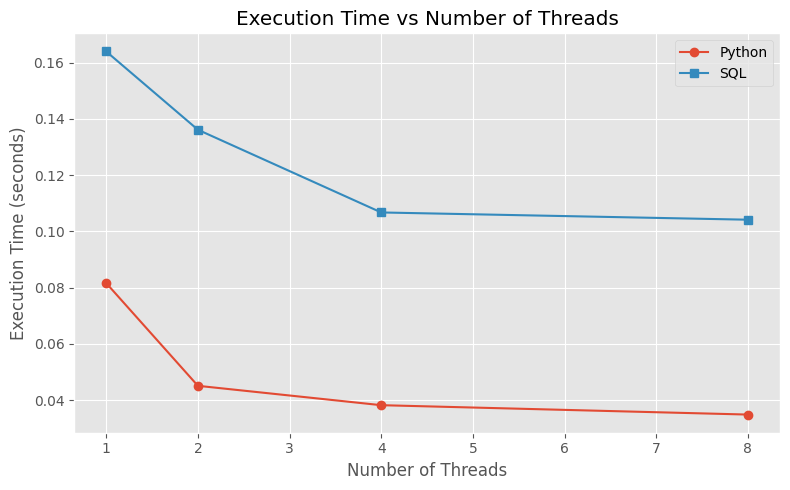

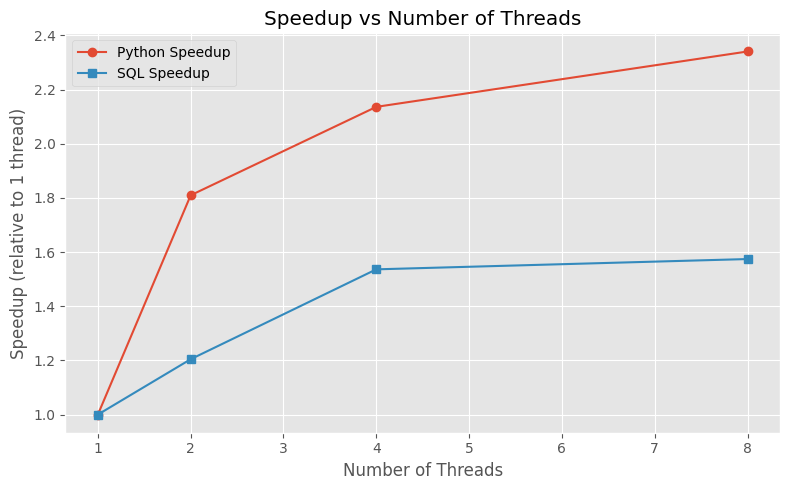

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(thread_counts, execution_times, label="Python", marker='o')
plt.plot(thread_counts, execution_times_sql, label="SQL", marker='s')
plt.xlabel("Number of Threads")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time vs Number of Threads")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def compute_speedup(times):
    return [times[0] / t for t in times]

plt.figure(figsize=(8, 5))
plt.plot(thread_counts, compute_speedup(execution_times), label="Python Speedup", marker='o')
plt.plot(thread_counts, compute_speedup(execution_times_sql), label="SQL Speedup", marker='s')
plt.xlabel("Number of Threads")
plt.ylabel("Speedup (relative to 1 thread)")
plt.title("Speedup vs Number of Threads")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# fastqc-rs vs our implementation - Comparison
First we compared base fastqc-rs execution time with our implementation

In [ ]:
import subprocess
import time
import polars_bio as pb
import os
import json
from statistics import mean
from collections import defaultdict

FASTQ_FILE = "../tests/data/small2.fastq"
HTML_REPORT = "fastqc_rs_report.html"
SUMMARY_JSON_DIR = "../fastqc_rs_output"
SUMMARY_FILE = os.path.join(SUMMARY_JSON_DIR, "fastqc_data.txt")
THREADS = 8
FQC_BIN = "/home/rafalunix/fastqc-rs/target/release/fqc"

def run_polars_bio_base_content(fastq_file: str, threads: int):
    pb.ctx.set_option("datafusion.execution.target_partitions", str(threads))

    start_read = time.perf_counter()
    df = pb.read_fastq(fastq_file).collect()
    end_read = time.perf_counter()
    read_time = end_read - start_read

    start_query = time.perf_counter()
    df = pb.qc.base_content(df)
    end_query = time.perf_counter()
    query_time = end_query - start_query
    print(df)

    bases = {"A": [], "T": [], "G": [], "C": [], "N": []}
    for row in df.rows():
        struct = row
        if isinstance(struct, dict):
            bases["A"].append(struct["A"])
            bases["T"].append(struct["T"])
            bases["G"].append(struct["G"])
            bases["C"].append(struct["C"])
            bases["N"].append(struct["N"])
        else:
            bases["A"].append(struct[1])
            bases["T"].append(struct[4])
            bases["G"].append(struct[3])
            bases["C"].append(struct[2])
            bases["N"].append(struct[5])

    avg_base_content = {b: mean(values) for b, values in bases.items()}
    return avg_base_content, read_time, query_time

def run_fastqc_rs(fastq_file: str, html_output_file: str, summary_dir: str):
    os.makedirs(summary_dir, exist_ok=True)

    start = time.perf_counter()
    subprocess.run([FQC_BIN, "-q", fastq_file, "-s", summary_dir], stderr=subprocess.DEVNULL, check=True)
    end = time.perf_counter()

    return end - start

def parse_base_content_fastqc_rs(summary_file: str):
    in_section = False
    base_counts = defaultdict(list)

    with open(summary_file, "r") as f:
        for line in f:
            line = line.strip()

            if line.startswith(">>Per base sequence content"):
                in_section = True
                continue

            if in_section and line.startswith(">>END_MODULE"):
                break

            if in_section and (line.startswith("#") or line == "pass"):
                continue

            if in_section:
                fields = line.split("\t")
                if len(fields) != 5:
                    continue
                _, g, a, t, c = map(float, fields)
                base_counts["G"].append(g)
                base_counts["A"].append(a)
                base_counts["T"].append(t)
                base_counts["C"].append(c)

    if not base_counts:
        raise ValueError("Valid base content data not found in summary.txt")

    avg_base_content = {b: mean(vs) * 100 for b, vs in base_counts.items()}
    avg_base_content["N"] = 0.0

    return avg_base_content

def compare_dicts(d1, d2):
    print("\n=== BASE CONTENT COMPARISON (%) ===")
    for base in ["A", "T", "G", "C"]:
        v1 = d1[base]
        v2 = d2[base]
        diff = abs(v1 - v2)
        print(f"{base}: polars-bio = {v1:.2f}%, fastqc-rs = {v2:.2f}%, diff = {diff:.3f}%")

base_content_polars, read_time_polars, query_time_polars = run_polars_bio_base_content(FASTQ_FILE, THREADS)
time_fastqc = run_fastqc_rs(FASTQ_FILE, HTML_REPORT, SUMMARY_JSON_DIR)
base_content_fastqc = parse_base_content_fastqc_rs(SUMMARY_FILE)

os.remove(SUMMARY_FILE)
os.rmdir(SUMMARY_JSON_DIR)



In [10]:
compare_dicts(base_content_polars, base_content_fastqc)

print("\n=== POLARS-BIO TIMING ===")
print(f"Read time    : {read_time_polars:.3f} s")
print(f"Query time   : {query_time_polars:.3f} s")
print(f"Total (R+Q)  : {read_time_polars + query_time_polars:.3f} s")

print("\n=== FASTQC-RS TIMING ===")
print(f"Total time   : {time_fastqc:.3f} s")


=== BASE CONTENT COMPARISON (%) ===
A: polars-bio = 29.86%, fastqc-rs = 29.86%, diff = 0.000%
T: polars-bio = 30.25%, fastqc-rs = 30.25%, diff = 0.000%
G: polars-bio = 19.86%, fastqc-rs = 19.86%, diff = 0.000%
C: polars-bio = 20.01%, fastqc-rs = 20.01%, diff = 0.000%

=== POLARS-BIO TIMING ===
Read time    : 5.076 s
Query time   : 2.692 s
Total (R+Q)  : 7.768 s

=== FASTQC-RS TIMING ===
Total time   : 7.304 s


Then we modified fastqc-rs to only perform base content calculation. Here are the results

In [ ]:
import subprocess
import time
import polars_bio as pb
import os
import json
from statistics import mean
from collections import defaultdict

FASTQ_FILE = "../tests/data/small2.fastq"
HTML_REPORT = "fastqc_rs_report.html"
SUMMARY_JSON_DIR = "../fastqc_rs_output2"
SUMMARY_FILE = os.path.join(SUMMARY_JSON_DIR, "fastqc_data.txt")
THREADS = 8
FQC_BIN = "/home/rafalunix/fastqc-rs/target/release/fqc"

def run_polars_bio_base_content(fastq_file: str, threads: int):
    pb.ctx.set_option("datafusion.execution.target_partitions", str(threads))

    start_read = time.perf_counter()
    df = pb.read_fastq(fastq_file).collect()
    end_read = time.perf_counter()
    read_time = end_read - start_read

    start_query = time.perf_counter()
    df = pb.qc.base_content(df)
    end_query = time.perf_counter()
    query_time = end_query - start_query

    bases = {"A": [], "T": [], "G": [], "C": [], "N": []}
    for row in df.rows():
        struct = row
        if isinstance(struct, dict):
            bases["A"].append(struct["A"])
            bases["T"].append(struct["T"])
            bases["G"].append(struct["G"])
            bases["C"].append(struct["C"])
            bases["N"].append(struct["N"])
        else:
            bases["A"].append(struct[1])
            bases["T"].append(struct[4])
            bases["G"].append(struct[3])
            bases["C"].append(struct[2])
            bases["N"].append(struct[5])

    avg_base_content = {b: mean(values) for b, values in bases.items()}
    return avg_base_content, read_time, query_time

def run_fastqc_rs(fastq_file: str, html_output_file: str, summary_dir: str):
    os.makedirs(summary_dir, exist_ok=True)

    start = time.perf_counter()
    subprocess.run([FQC_BIN, "-q", fastq_file, "-s", summary_dir], stderr=subprocess.DEVNULL, check=True)
    end = time.perf_counter()

    return end - start

def parse_base_content_fastqc_rs(summary_file: str):
    in_section = False
    base_counts = defaultdict(list)

    with open(summary_file, "r") as f:
        for line in f:
            line = line.strip()

            if line.startswith(">>Per base sequence content"):
                in_section = True
                continue

            if in_section and line.startswith(">>END_MODULE"):
                break

            if in_section and (line.startswith("#") or line == "pass"):
                continue

            if in_section:
                fields = line.split("\t")
                if len(fields) != 5:
                    continue
                _, g, a, t, c = map(float, fields)
                base_counts["G"].append(g)
                base_counts["A"].append(a)
                base_counts["T"].append(t)
                base_counts["C"].append(c)

    if not base_counts:
        raise ValueError("Valid base content data not found in summary.txt")

    avg_base_content = {b: mean(vs) * 100 for b, vs in base_counts.items()}
    avg_base_content["N"] = 0.0

    return avg_base_content

def compare_dicts(d1, d2):
    print("\n=== BASE CONTENT COMPARISON (%) ===")
    for base in ["A", "T", "G", "C"]:
        v1 = d1[base]
        v2 = d2[base]
        diff = abs(v1 - v2)
        print(f"{base}: polars-bio = {v1:.2f}%, fastqc-rs = {v2:.2f}%, diff = {diff:.3f}%")

base_content_polars, read_time_polars, query_time_polars = run_polars_bio_base_content(FASTQ_FILE, THREADS)
time_fastqc = run_fastqc_rs(FASTQ_FILE, HTML_REPORT, SUMMARY_JSON_DIR)
base_content_fastqc = parse_base_content_fastqc_rs(SUMMARY_FILE)

os.remove(SUMMARY_FILE)
os.rmdir(SUMMARY_JSON_DIR)



In [3]:
compare_dicts(base_content_polars, base_content_fastqc)

print("\n=== POLARS-BIO TIMING ===")
print(f"Read time    : {read_time_polars:.3f} s")
print(f"Query time   : {query_time_polars:.3f} s")
print(f"Total (R+Q)  : {read_time_polars + query_time_polars:.3f} s")

print("\n=== FASTQC-RS TIMING ===")
print(f"Total time   : {time_fastqc:.3f} s")


=== BASE CONTENT COMPARISON (%) ===
A: polars-bio = 2986.30%, fastqc-rs = 29.86%, diff = 2956.437%
T: polars-bio = 3024.68%, fastqc-rs = 30.25%, diff = 2994.429%
G: polars-bio = 1985.65%, fastqc-rs = 19.86%, diff = 1965.794%
C: polars-bio = 2001.16%, fastqc-rs = 20.01%, diff = 1981.146%

=== POLARS-BIO TIMING ===
Read time    : 8.126 s
Query time   : 3.542 s
Total (R+Q)  : 11.668 s

=== FASTQC-RS TIMING ===
Total time   : 3.940 s


## Conclusion

In this notebook, we demonstrated how to use the `base_content` function from the `polars_bio.qc` module to analyze and visualize the base sequence content of FASTQ files. This QC operation helps identify biases or issues in the sequencing process.

Key points:
- The function calculates the percentage of each base (A, T, G, C, N) at each position in the reads
- It supports different input types (Polars DataFrame, Polars LazyFrame, Pandas DataFrame)
- The operation can be parallelized for better performance on larger datasets
- The results can be easily visualized to identify patterns or anomalies in the data

This QC operation is an essential part of NGS data analysis pipelines, helping researchers ensure the quality of their sequencing data before proceeding with downstream analyses.